In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass, field

from typing import Dict, List, Tuple, Optional, Callable, Any

import math
import numpy as np
from PIL import Image

from pysolotools.consumers import Solo
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.core.models import KeypointAnnotationDefinition, RGBCameraCapture
from pysolotools.core.models import BoundingBox2DLabel, BoundingBox2DAnnotation
from pysolotools.core.models import BoundingBox3DLabel, BoundingBox3DAnnotation
from pysolotools.core.models import Frame, Capture
from scipy.spatial.transform import Rotation as R

from torchvision.datasets import ImageFolder
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
# from torch.utils.data import ConcatDataset, DataLoader
from collections import OrderedDict
from torch.utils.data import DataLoader

import torch
from torch import nn, Tensor

from torch.nn import functional as F
import torchprofile

from torchvision.ops import FeaturePyramidNetwork, MLP, sigmoid_focal_loss
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor

import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.io import savemat

import reader
import utils
import network
import transformer
import cvmpca_main as cvmpca
from torchvision.ops import FeaturePyramidNetwork
from my_trainer import SetCriterion

torch.set_float32_matmul_precision('medium')
# %matplotlib ipympl

c:\Users\LeonardNgo\miniconda3\envs\cvmpa\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
train_folder = 'D:/Unity/dataset/solo'
# training_dir = './data/train'
# testing_dir = './data/test'

In [6]:
# train_loader = reader.UnityDataset.from_unity_to_loader(root=train_folder, batch_size=2)
train_loader = reader.UnityMatDataset.from_unity_to_loader(root=train_folder, batch_size=2)


for batch in train_loader:
    feature_dicts, object_list = batch

    break

Dataset loaded succesfully.


In [10]:
trainer = pl.Trainer(
    max_epochs=20, #precision='16-mixed',
    gradient_clip_val=35,
    log_every_n_steps=20,
    # accelerator="cpu",
    # profiler="simple",
    # detect_anomaly=True
)
net = cvmpca.CVMPCA(
    train_loader.dataset.captures,
    n_classes=len(train_loader.dataset.category_lookup)-1,
    space=[[-11, 11], [0, 3], [-7, 7]],
    voxel_size=[0.075, 0.2, 0.075],
    ratio=3,
)

trainer.fit(net, train_dataloaders=train_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params
--------------------------------------------------
0 | cameras | ModuleDict            | 0     
1 | fpn     | FeaturePyramidNetwork | 470 K 
2 | ray_pe  | Conv2d                | 384   
3 | blocks  | ModuleList            | 363 K 
4 | heads   | ModuleList            | 99.4 K
--------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.735     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from matplotlib import pyplot as plt

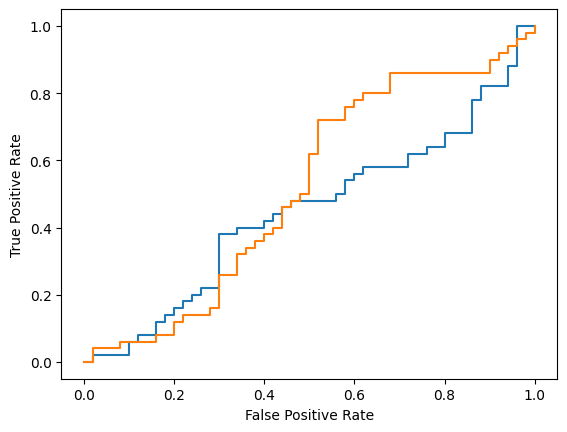

In [24]:
N = 100

y_true = np.ones(N)

# y_pred = y_pred[:, 0]
y_true[:N//2] = 0

for _ in range(2):
    y_pred = np.random.rand(N)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr)  # , label="data 1, auc="+str(auc))
# plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [23]:
thresholds

array([       inf, 0.99731917, 0.99019287, 0.97464445, 0.93735576,
       0.93043245, 0.91119101, 0.91086317, 0.8477517 , 0.83840818,
       0.81652572, 0.74597496, 0.73838312, 0.73230162, 0.72263824,
       0.71229296, 0.70946707, 0.70943306, 0.70585713, 0.67425769,
       0.6484998 , 0.63335423, 0.63102493, 0.61050183, 0.60612757,
       0.59699966, 0.58810936, 0.58580545, 0.56351828, 0.54160792,
       0.54007427, 0.49541666, 0.47108474, 0.41972303, 0.40667773,
       0.38354891, 0.36089025, 0.34935317, 0.31098408, 0.31038632,
       0.29659199, 0.29504808, 0.24542843, 0.23155018, 0.20556544,
       0.20436141, 0.18246089, 0.17954559, 0.13036066, 0.05952257,
       0.05076136, 0.05043703, 0.02997516, 0.02630994, 0.00462344])